## NB - binary classification

#### "is_from_NorthAmerica" -> non va molto bene

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [16]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

## tolgo record con outliers -> non va perchè dovrei cambiare i bin

In [17]:
# pp_class = pp_class[pp_class['outlier']!=True]
# pp_test_class = pp_test_class[pp_test_class['outlier']!=True]

one hot encoding title type


In [18]:
from sklearn.preprocessing import OneHotEncoder

# Estrai la colonna da codificare
title_type = pp_class[['titleType']]
title_type_test = pp_test_class[['titleType']]

# Inizializza l'encoder
encoder = OneHotEncoder(sparse=False, drop=None)  # drop='first' se vuoi evitare collinearità

# Esegui la codifica
title_encoded = encoder.fit_transform(title_type)
title_encoded_test = encoder.fit_transform(title_type_test)

# Crea un DataFrame con i nomi delle colonne
title_encoded_df = pd.DataFrame(title_encoded, columns=encoder.get_feature_names_out(['titleType']))
title_encoded_df_test = pd.DataFrame(title_encoded_test, columns=encoder.get_feature_names_out(['titleType']))


# Unisci al dataset originale
pp_class= pd.concat([pp_class.reset_index(drop=True), title_encoded_df], axis=1)
pp_test_class= pd.concat([pp_test_class.reset_index(drop=True), title_encoded_df_test], axis=1)


# (Facoltativo) Rimuovi la colonna originale
pp_class#.drop(columns=['titleType'], inplace=True)


C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,runtimeMinutes_notitletype_imputed,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,titleType_tvShort,titleType_tvSpecial,titleType_video
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,1995.0,NaN,0.0,779,1,0,21,...,89.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Idealnaya para,6,1992,1992.0,NaN,0.0,38,1,0,24,...,75.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,22,0,56,...,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Seutateueob,8,2020,2020.0,80.0,1.0,15718,347,2,47,...,80.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Lightdance,9,1995,1995.0,34.0,0.0,14,1,0,0,...,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16167,Caprices,6,1942,1942.0,NaN,0.0,73,4,0,45,...,49.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16168,Haar Jeet,5,1990,1990.0,NaN,0.0,15,2,0,22,...,78.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16169,Kotigobba 3,6,2021,2021.0,140.0,0.0,2560,39,3,129,...,140.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16170,Ator l'invincibile,4,1982,1982.0,NaN,0.0,3011,52,1,53,...,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

## Filtro dataset su classi meno rappresentate -> capire se 1,5,6,9 o 7,8,9

In [20]:
 #pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

### Selezione variabile target

In [21]:
y_train = np.array(pp_class['is_from_North America'])  # Il target originale
y_test = np.array(pp_test_class["is_from_North America"])

### preprocessing variabili

In [22]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

pp_class['isAdult'] = pp_class['isAdult'].astype(int)
pp_test_class['isAdult'] = pp_test_class['isAdult'].astype(int)

In [23]:
column2drop = ['originalTitle', 'runtimeMinutes']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

#### endYear da gestire

In [24]:
pp_class= pp_class.drop(["endYear"], axis=1)
pp_test_class= pp_test_class.drop(["endYear"], axis=1)

## RUNTIME MINUTES IMPUTED-> TOLTA PERCH HA NAN

In [25]:
pp_class= pp_class.drop(["runtimeMinutes_imputed"], axis=1)
pp_test_class= pp_test_class.drop(["runtimeMinutes_imputed"], axis=1)


#### Discretizzazione delle numeriche

In [26]:
#TOTAL NOMINATIONS E TOTAL MEDIA
# 1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)

pp_class['totalNominations_bin'] = (pp_class['totalNominations'] > 0).astype(int)
pp_class['totalMedia_bin'] = (pp_class['totalMedia'] > 0).astype(int)

pp_test_class['totalNominations_bin'] = (pp_test_class['totalNominations'] > 0).astype(int)
pp_test_class['totalMedia_bin'] = (pp_test_class['totalMedia'] > 0).astype(int)


In [27]:
#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_class['totalNominations_bin'] = pd.cut(pp_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

bins = [-1, 0, 2, 10, pp_test_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_test_class['totalNominations_bin'] = pd.cut(pp_test_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_class['media_bin'] = pd.cut(pp_class['totalMedia'], bins=bins, labels=labels)


bins = [-1, 0, 1, 8, 50, pp_test_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_test_class['media_bin'] = pd.cut(pp_test_class['totalMedia'], bins=bins, labels=labels)


In [28]:
#train

#FILL_RUNTIMEMINS_BRUNO 
bins = [-1, 25, 60, 120, 180, pp_class['fill_runtimeMinutes_Bruno'].max()]
labels = ['VeryLowRuntime', 'LowRuntime', 'MediumRuntime', 'HighRuntime', "VeryHighRuntime"]
pp_class['runtime_bin'] = pd.cut(pp_class['fill_runtimeMinutes_Bruno'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_class['rating'].max()]
labels = ['VeryLowRating', 'LowRating', 'MediumRating', 'HighRating', "VeryHighRating"]
pp_class['rating_bin'] = pd.cut(pp_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['VeryLowVotes', 'LowVotes', 'MediumVotes', 'HighVotes', 'VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_class['numVotes_bin'] = pd.cut(pp_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1878,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_class['startYear'].max()] #era corrente
labels = ['pre-1930', '1930-1954', '1955-1979', '1980-1999', '2000-2019', 'post-2020']
pp_class['startYear_bin'] = pd.cut(pp_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['VeryLowCredits', 'LowCredits', 'MediumCredits', 'HighCredits', 'VeryHighCredits']
bins = [-1, 15, 35, 65, 200, float('inf')]
pp_class['totalCredits_bin'] = pd.cut(pp_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    'NoCriticReviews',
    'FewCriticReviews',
    'ModerateCriticReviews',
    'ManyCriticReviews',
    'VeryHighCriticReviews',
    'ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_class['criticReviewsTotal_bin'] = pd.cut(pp_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['VeryFewRegions', 'ModerateRegions', 'ManyRegions', 'GlobalRegions']
bins = [0, 1, 3, 8, float('inf')]
pp_class['numRegions_bin'] = pd.cut(pp_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['NoUserReviews', 'FewUserReviews', 'ManyUserReviews', 'VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]
pp_class['userReviewsTotal_bin'] = pd.cut(pp_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN freq-> CANCELLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['LowFreqCountries', 'MediumFreqCountries', 'HighFreqCountries']
pp_class["country_freq_bin"] = pd.cut( pp_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> CANCELLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_class, "countryOfOrigin_UNK", "from_Unknown")


In [29]:
#test

#FILL_RUNTIMEMINS_BRUNO 
bins = [-1, 25, 60, 120, 180, pp_test_class['fill_runtimeMinutes_Bruno'].max()]
labels = ['VeryLowRuntime', 'LowRuntime', 'MediumRuntime', 'HighRuntime', "VeryHighRuntime"]
pp_test_class['runtime_bin'] = pd.cut(pp_test_class['fill_runtimeMinutes_Bruno'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_test_class['rating'].max()]
labels = ['VeryLowRating', 'LowRating', 'MediumRating', 'HighRating', "VeryHighRating"]
pp_test_class['rating_bin'] = pd.cut(pp_test_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['VeryLowVotes', 'LowVotes', 'MediumVotes', 'HighVotes', 'VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_test_class['numVotes_bin'] = pd.cut(pp_test_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1877,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_test_class['startYear'].max()] #era corrente
labels = ['pre-1930', '1930-1954', '1955-1979', '1980-1999', '2000-2019', 'post-2020']
pp_test_class['startYear_bin'] = pd.cut(pp_test_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['VeryLowCredits', 'LowCredits', 'MediumCredits', 'HighCredits', 'VeryHighCredits']
bins = [-1, 15, 35, 65, 200, float('inf')]

pp_test_class['totalCredits_bin'] = pd.cut(pp_test_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    'NoCriticReviews',
    'FewCriticReviews',
    'ModerateCriticReviews',
    'ManyCriticReviews',
    'VeryHighCriticReviews',
    'ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_test_class['criticReviewsTotal_bin'] = pd.cut(pp_test_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['VeryFewRegions', 'ModerateRegions', 'ManyRegions', 'GlobalRegions']
bins = [0, 1, 3, 8, float('inf')]
pp_test_class['numRegions_bin'] = pd.cut(pp_test_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['NoUserReviews', 'FewUserReviews', 'ManyUserReviews', 'VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]

pp_test_class['userReviewsTotal_bin'] = pd.cut(pp_test_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN FREQ ENC 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['LowFreqCountries', 'MediumFreqCountries', 'HighFreqCountries']

pp_test_class["country_freq_bin"] = pd.cut( pp_test_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_test_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_test_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_test_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_test_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_test_class, "countryOfOrigin_UNK", "from_Unknown")


In [30]:
pp_class.columns

Index(['rating', 'startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType',
       'awardNominationsExcludeWins',
       ...
       'numRegions_bin', 'userReviewsTotal_bin', 'country_freq_bin',
       'from_NorthAmerica_bin', 'from_Europe_bin', 'from_SouthAmerica_bin',
       'from_Asia_bin', 'from_Oceania_bin', 'from_Africa_bin',
       'from_Unknown_bin'],
      dtype='object', length=101)

## array di valori per selezione feature classificazione

In [31]:
#  PROVA CATEGORICAL


X_train = pp_class[[
       'rating_bin',
       'startYear_bin', # tolto perchè ha 1 Nan -> chissà dove       
       'numVotes_bin',
       'totalCredits_bin', 
       'criticReviewsTotal_bin',
       'canHaveEpisodes', 
       'userReviewsTotal_bin',
       'runtime_bin',
        'totalNominations_bin',
       # 'numRegions_bin',
        'titleType_movie','titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries','titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvShort', 'titleType_tvSpecial', 'titleType_video'
       #'totalMedia_bin',
       #'countryOfOrigin_freq_enc', ## -> migliora di troppo
       ]].values

X_test = pp_test_class[[ 
       'rating_bin',
       'startYear_bin', # tolto perchè ha 1 Nan -> chissà dove
       'numVotes_bin',
       'totalCredits_bin', 
       'criticReviewsTotal_bin',
       'canHaveEpisodes', 
       'userReviewsTotal_bin',
       'runtime_bin',
       'totalNominations_bin',
       # 'numRegions_bin',
        'titleType_movie','titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries','titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvShort', 'titleType_tvSpecial', 'titleType_video'
       #'totalMedia_bin',
       #'countryOfOrigin_freq_enc', ## -> migliora di troppo
]].values




In [32]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


### Splitting in validation

In [33]:
#CATEGORICAL NB
X_train2, X_val, y_train2, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=32)

In [34]:
print(X_train2.shape, X_val.shape, X_train.shape,
      #, X_test.shape
      )

(12937, 18) (3235, 18) (16172, 18)


In [35]:

X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## NAIVE BAYES

### Categorical

In [36]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) -> non va perchè ci sono valori negativi
clf = CategoricalNB()
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

Predicting on validation set

In [37]:
y_pred = clf.predict(X_val_tr)

In [38]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3235
3235


In [39]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1}
{0, 1}


Classification report

In [40]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.6695517774343122

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      1693
           1       0.66      0.64      0.65      1542

    accuracy                           0.67      3235
   macro avg       0.67      0.67      0.67      3235
weighted avg       0.67      0.67      0.67      3235



In [41]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[0.91580346, 0.08419654],
       [0.56277673, 0.43722327],
       [0.84291974, 0.15708026],
       ...,
       [0.86700954, 0.13299046],
       [0.88565755, 0.11434245],
       [0.16709593, 0.83290407]])

overfitting

Performance sul Training set:
Accuracy: 0.6709
F1 Score: 0.6708

Performance sul Validation set:
Accuracy: 0.6696
F1 Score: 0.6694


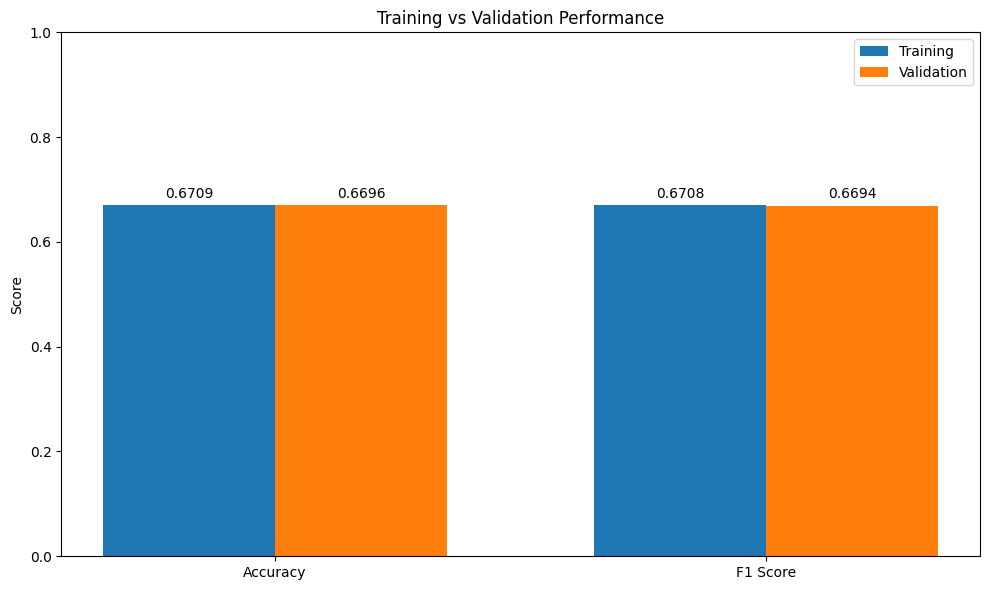

In [42]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

In [43]:
print("y_val shape:", y_val.shape)
print("y_val dtype:", y_val.dtype)
print("primi elementi di y_val:", y_val[:5])  # Mostra i primi 5 elementi

y_val shape: (3235,)
y_val dtype: int64
primi elementi di y_val: [0 0 0 0 0]


In [44]:
# plot_roc(y_val, clf.predict_proba(X_val_tr))
# plt.show()
# print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

prova 2 roc

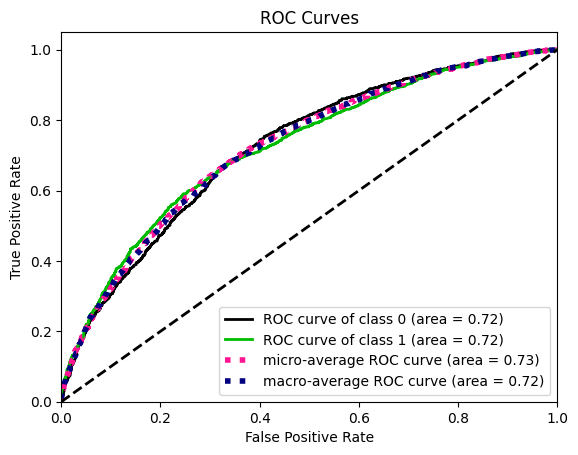

0.7236132147095349


In [45]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

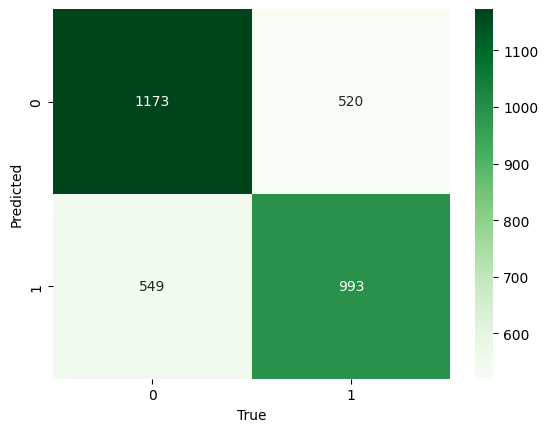

In [46]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

Distribuzioni classi nel train2

In [47]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    6760
1    6177
Name: count, dtype: int64


## Proper testing on the test set

In [48]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

Performance sul Training set:
Accuracy: 0.6709
F1 Score: 0.6708

Performance sul test set:
Accuracy: 0.6727
F1 Score: 0.6726


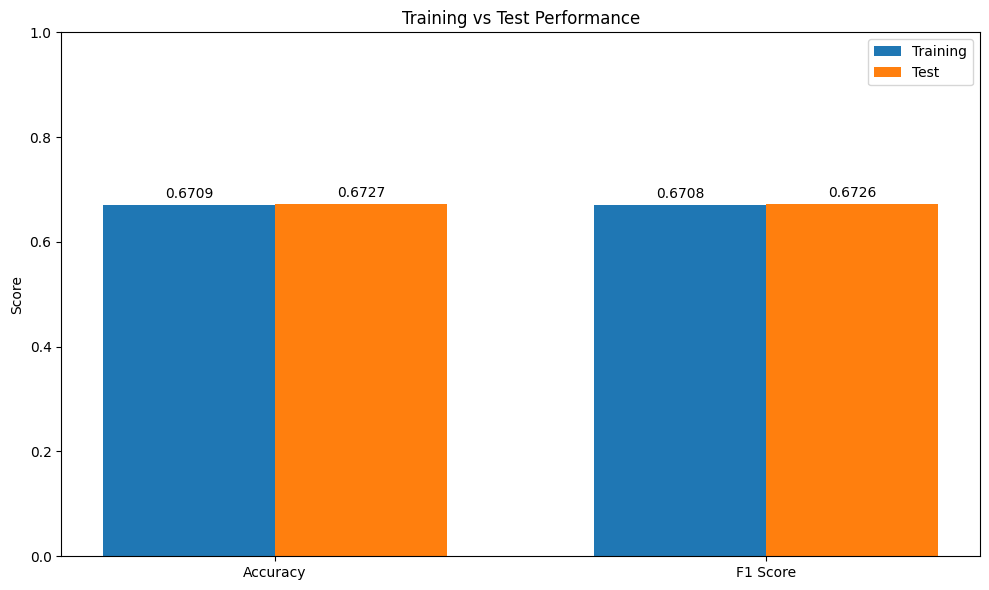

In [49]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [50]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.6727340267459139

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      2844
           1       0.66      0.64      0.65      2540

    accuracy                           0.67      5384
   macro avg       0.67      0.67      0.67      5384
weighted avg       0.67      0.67      0.67      5384



In [51]:
clf.predict_proba(X_test_tr)
#prob che un record appartenga alle classi

array([[0.3478776 , 0.6521224 ],
       [0.41416409, 0.58583591],
       [0.64055064, 0.35944936],
       ...,
       [0.91815466, 0.08184534],
       [0.4076751 , 0.5923249 ],
       [0.95836817, 0.04163183]])

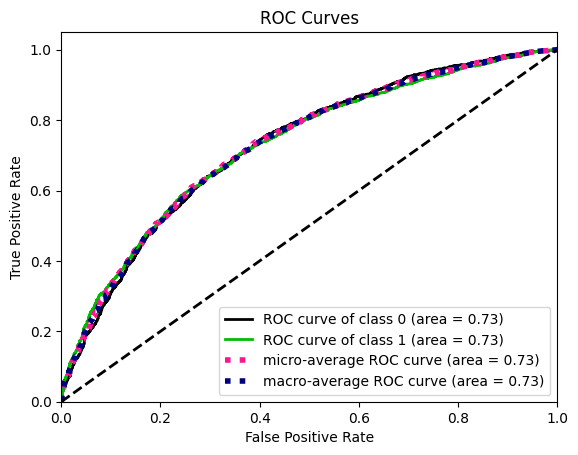

0.7268432921359513


In [52]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_test_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_test, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_test, probs[:, 1]))

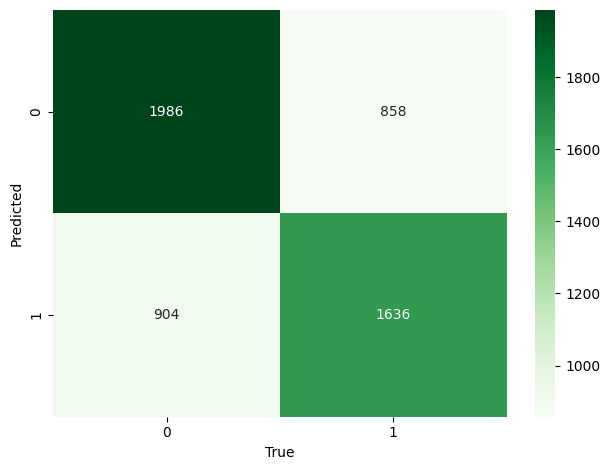

In [53]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### devo cambiare qlcs? Dummy classifier

In [54]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5282317979197623
Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69      2844
           1       0.00      0.00      0.00      2540

    accuracy                           0.53      5384
   macro avg       0.26      0.50      0.35      5384
weighted avg       0.28      0.53      0.37      5384



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# "lowEngagement"

In [55]:
pp_class["lowEngagement"] = (pp_class["numVotes"]<100).astype(int)
pp_test_class["lowEngagement"] = (pp_test_class["numVotes"]<100).astype(int)

In [56]:
x = sum(pp_class["lowEngagement"] == 1)
x

11105

Selezione variabile target

In [57]:
y_train = np.array(pp_class["lowEngagement"]) #target originale
y_test = np.array(pp_test_class["lowEngagement"])

Selezione attributi per classificazione

In [58]:
X_train = pp_class[[
       'rating_bin',
       'totalCredits_bin', 
       'canHaveEpisodes', 
       'numRegions_bin', 
       'country_freq_bin',
       'runtime_bin',  
       'totalNominations_bin',
       'totalMedia_bin',
       'startYear_bin',
       ]].values

X_test = pp_test_class[[      
       'rating_bin',
       'totalCredits_bin', 
       'canHaveEpisodes', 
       'numRegions_bin', 
       'country_freq_bin',
       'runtime_bin',  
       'totalNominations_bin',
       'totalMedia_bin',
       'startYear_bin',
       ]].values

In [59]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


In [60]:
#studio variabili da usare

# X_train = pp_class[[
#        'rating',
#        #'startYear',  
#        #'numVotes', 
#        'totalCredits',  
#        'criticReviewsTotal', # FORSEEEE toglere perchè simili
#        ##'canHaveEpisodes', 
#        ##'isAdult',  -> era simie
#        'numRegions', 
#        'userReviewsTotal', # toglirtr perchè simile
#        ##'endYear',
#        #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
#        #'fill_runtimeMinutes',  #lasciare
#        #'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
#        ##'awardWins_bin',  
#        ##'totalVideos_bin', 
#        ##'awardNominationsExcludeWins_bin', 

#        #'countryOfOrigin', 
#        'countryOfOrigin_freq_enc',
#        #'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK', 
#        'fill_runtimeMinutes_Bruno',  
#        #'totalNominations',
#        #'totalMedia', 
#        'totalNominations_bin',
#       # 'totalMedia_bin',
#       # 'runtimeMinutes_notitletype' 
#        ]].values

# ## X_test = pp_test_class[[ ]].values

Splitting in train-validation

In [61]:
#CATEGORICAL NB
X_train2, X_val, y_train2, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=32)

In [62]:
X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## Naive Bayes

In [63]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) #-> non va perchè ci sono valori negativi
clf = CategoricalNB()
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

Prediction on validation set

In [64]:
y_pred = clf.predict(X_val_tr)

In [65]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3235
3235


In [66]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8012364760432766

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.54      0.63      1014
           1       0.82      0.92      0.86      2221

    accuracy                           0.80      3235
   macro avg       0.78      0.73      0.75      3235
weighted avg       0.80      0.80      0.79      3235



In [67]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[0.16374143, 0.83625857],
       [0.02922102, 0.97077898],
       [0.00790377, 0.99209623],
       ...,
       [0.05882437, 0.94117563],
       [0.10696468, 0.89303532],
       [0.46210839, 0.53789161]])

Performance sul Training set:
Accuracy: 0.7952
F1 Score: 0.7876

Performance sul Validation set:
Accuracy: 0.8012
F1 Score: 0.7911


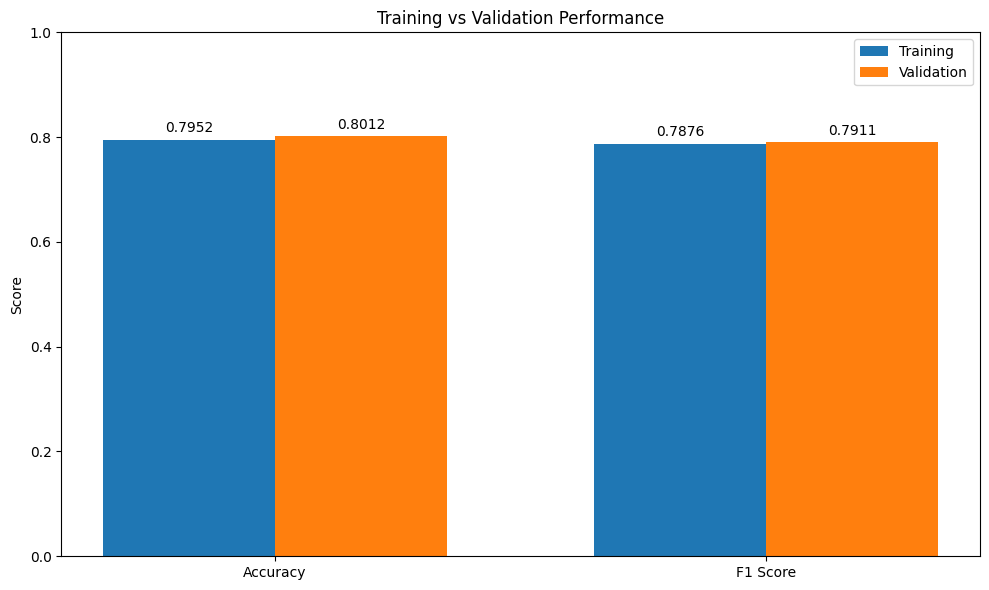

In [68]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

ROC curve

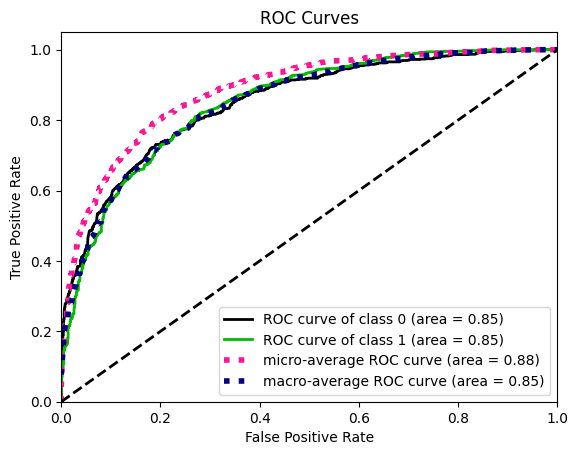

0.8492942568116605


In [69]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_val_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_val, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_val, probs[:, 1]))

Confusion matrix

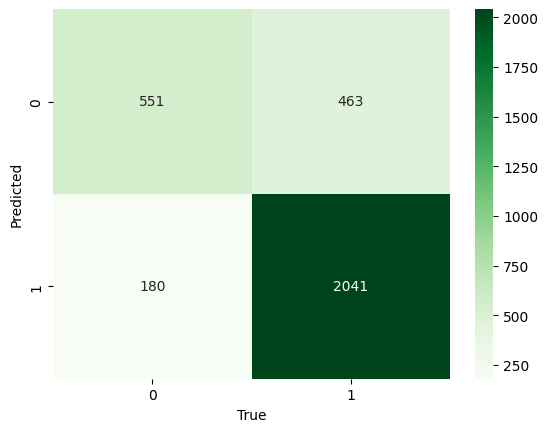

In [70]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## Prediction on the test set

In [71]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred

array([1, 1, 1, ..., 1, 0, 1])

Performance sul Training set:
Accuracy: 0.7964
F1 Score: 0.7886

Performance sul test set:
Accuracy: 0.7987
F1 Score: 0.7918


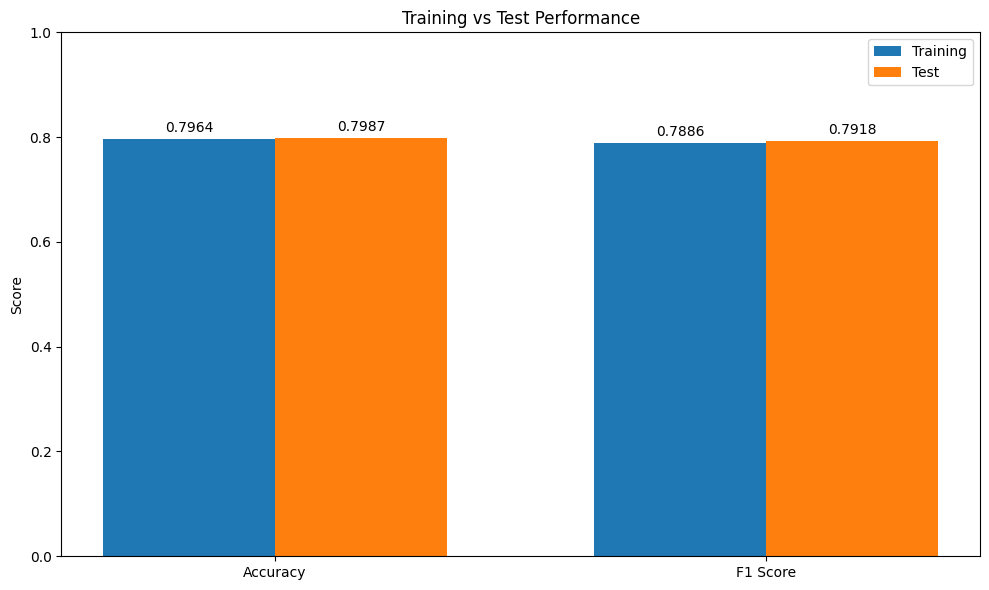

In [72]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

### risultati test

In [73]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.7986627043090639

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.58      0.64      1698
           1       0.82      0.90      0.86      3686

    accuracy                           0.80      5384
   macro avg       0.77      0.74      0.75      5384
weighted avg       0.79      0.80      0.79      5384



In [74]:
clf.predict_proba(X_test_tr)
#prob che un record appartenga alle classi

array([[0.03548138, 0.96451862],
       [0.41206107, 0.58793893],
       [0.0911885 , 0.9088115 ],
       ...,
       [0.10167083, 0.89832917],
       [0.75745799, 0.24254201],
       [0.10587266, 0.89412734]])

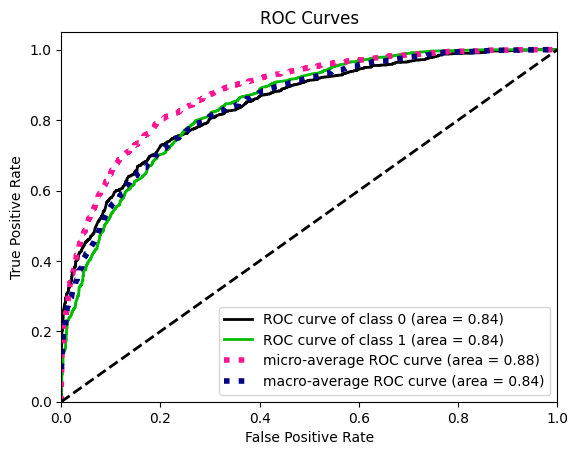

0.843119670328055


In [75]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_test_tr)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_test, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_test, probs[:, 1]))

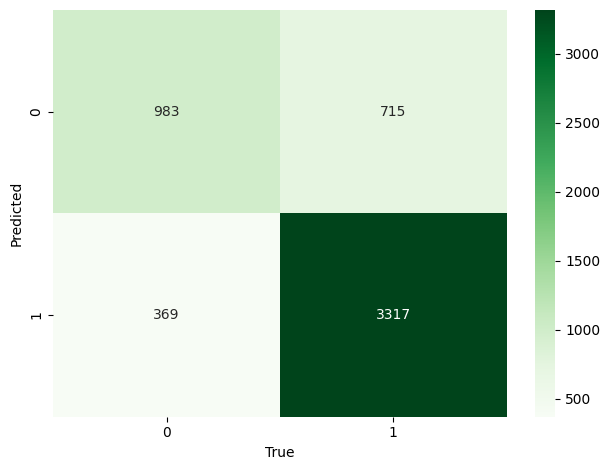

In [76]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

## Dummy classifier -> cambia qlcs?

In [77]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6846210995542348
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1698
           1       0.68      1.00      0.81      3686

    accuracy                           0.68      5384
   macro avg       0.34      0.50      0.41      5384
weighted avg       0.47      0.68      0.56      5384



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
